In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
timeEnd = datetime.datetime(2011,7,5,7,0)
sapsTime = datetime.datetime(2011,7,5,5,2)
saidTimeRange = [ datetime.datetime(2011,7,5,4,0),\
              datetime.datetime(2011,7,5,6,0) ]
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]
selBeam = 7
sapsMlatRange = [ 52., 63. ]#[ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 0 # per radar per beam
velScale = [ -500, 500 ]
velMagnScale = [ 0, 1000 ]
coords="mag"
# TEC variables
tecScale = [ 0, 10 ]
# discard the edge MLTs
# these are the MLTs we'll plot
# pltNormMltList = [ -4, -3, -2, -1, 0 ]

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

In [4]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF = lshellDF[ (lshellDF["velSAPS"] > 0.) &\
                    (lshellDF["velSAPS"] < 2000.) ].reset_index(drop=True)
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,15.083845,6.610516,1.5,True,59.0,-2.0,349.126369,33.397030,58.91,-2.34,2011-07-05 04:00:00,58.91,-2.34,-17.0,-22.0
1,15.704863,2.943747,1.5,True,59.0,-3.0,345.693567,19.495890,58.91,-3.33,2011-07-05 04:00:00,58.91,-3.33,-32.0,-37.0
2,4.222649,3.620818,1.5,True,59.5,-2.0,303.585017,29.043018,59.48,-2.30,2011-07-05 04:00:00,59.48,-2.30,-17.0,-22.0
3,19.073163,1.517291,1.5,True,58.5,-4.0,391.855314,28.287167,58.37,-4.37,2011-07-05 04:00:00,58.37,-4.37,-47.0,-53.0
4,15.200143,1.697521,1.5,True,59.0,-4.0,355.620902,23.967516,58.91,-4.34,2011-07-05 04:00:00,58.91,-4.34,-47.0,-52.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


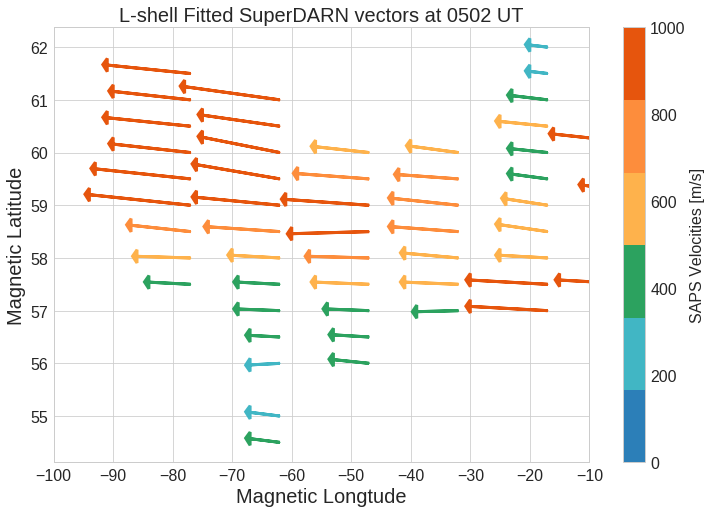

In [5]:
selSapsDF = lshellDF[ lshellDF["date"] == sapsTime ]
# print lshellDF["date"].unique()
selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
plotMLTends = selSapsDF['EndptMlon'].tolist()
plotmlatends = selSapsDF['endPtmlat'].tolist()
plotMLTbegins = selSapsDF['Mlon'].tolist()
plotmlatbegins = selSapsDF['mlat'].tolist()
plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()


# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
tecSeaMap = ListedColormap(sns.color_palette("Greys"))
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# lshlPlt = selSapsDF.plot( kind='scatter',
#               x='Mlon',
#               y='mlat',
#               c='SAPS speed [m/s]',
#               s=1., cmap=seaMap, vmin=velMagnScale[0],\
#               vmax=velMagnScale[1], ax=ax,fontsize=20)
lshellPlot = ax.scatter( x=selSapsDF["Mlon"], y=selSapsDF["mlat"],\
                     c=selSapsDF["SAPS speed [m/s]"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        if currMLTbgn <= currMLTend:
            print currMLTbgn, currMLTend
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.25, head_length=0.75, fc=currCol, ec=currCol, lw=3.)


ax.set_xlim( [-100,-10] )
# ax.set_ylim( [ 52., 65. ] )
ax.set_ylabel( "Magnetic Latitude", fontsize=20 )
ax.set_xlabel( "Magnetic Longtude", fontsize=20 )
ax.set_title("L-shell Fitted SuperDARN vectors at " +\
             sapsTime.strftime("%H%M") + " UT", fontsize=20)

ax.tick_params(labelsize=16)
cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(lshellPlot, cax=cax, orientation='horizontal')


f.savefig("../plots/lshell-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

In [6]:
# get a timeseries plot of the vectors
# for a given time, get max vectors at each MLT
selCols = [ 'normMlt', 'velSAPS', 'date' ]
maxVelgrpDF = lshellDF[selCols].groupby(\
            [ 'normMlt', 'date' ] \
            ).max().reset_index()
saidDF = pandas.merge( lshellDF, maxVelgrpDF, on=selCols )
saidDF = saidDF[ ['azimSAPS', 'mlat', 'normMlt',\
                  'velSAPS', 'date', 'Mlon'] ]
saidDF["time"] = [ date2num(x) for x in saidDF["date"] ]
saidDF["endPtmlat"] = numpy.round( (saidDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*saidDF["azimSAPS"]) ) +\
                                saidDF["mlat"], 2 )
saidDF["endPtTime"] = (saidDF["velSAPS"]/1e5) *\
                                numpy.cos( numpy.deg2rad(\
                                -90-1*saidDF["azimSAPS"]) ) +\
                                saidDF["time"]
saidDF["endPtnormMlt"] = numpy.round( (saidDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*saidDF["azimSAPS"]) ) +\
                                saidDF["normMlt"], 2 )
saidDF["endPtMlon"] = numpy.round( (saidDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*saidDF["azimSAPS"]) ) +\
                                saidDF["Mlon"], 2 )

saidDF = saidDF[ ( saidDF["date"] >= saidTimeRange[0] ) &\
               ( saidDF["date"] <= saidTimeRange[1] )\
               ].reset_index(drop=True)

In [7]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

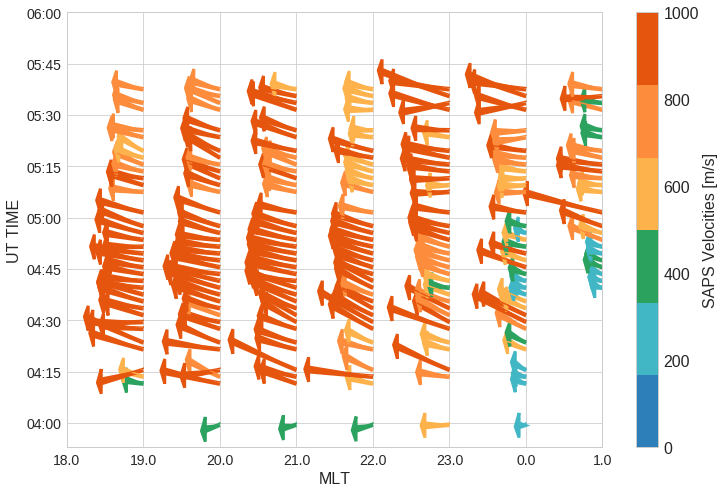

In [8]:
# setup data
plotMLTends = saidDF['endPtnormMlt'].tolist()#saidDF['endPtMlon'].tolist()#
plotmlatends = saidDF['endPtTime'].tolist()
plotMLTbegins = saidDF['normMlt'].tolist()#saidDF['Mlon'].tolist()#
plotmlatbegins = saidDF['time'].tolist()
plotVelMagns = saidDF['velSAPS'].tolist()
# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = saidTimeRange[0]
while currTime <= saidTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
    
lshellPlot = ax.scatter( x=saidDF["normMlt"], y=saidDF["time"],\
                     c=saidDF["velSAPS"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         print currMLTbgn, currMLTend
#         print currmlatbgn, currmlatend
        ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.005, head_length=0.05, fc=currCol, ec=currCol, lw=3.)
        
ax.set_xlim( [-6,1] )
ax.set_yticks(yTickList)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xlabel('MLT', fontsize=16)
ax.set_ylabel('UT TIME', fontsize=16)

cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)


f.savefig("../plots/lshell-timseries-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

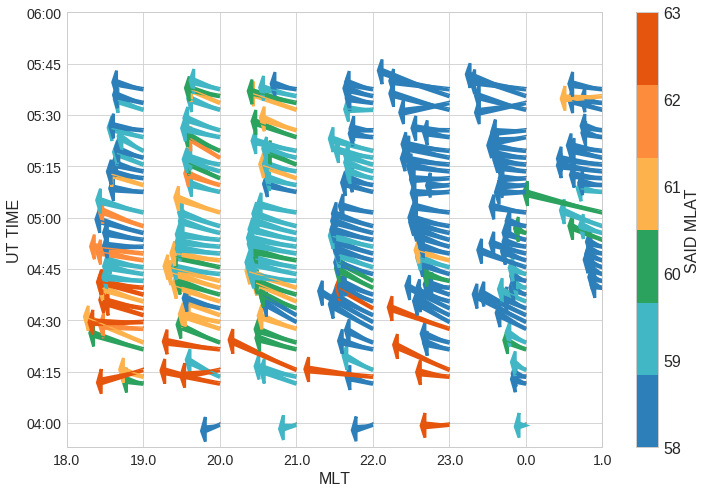

In [9]:
# setup data
plotMLTends = saidDF['endPtnormMlt'].tolist()#saidDF['endPtMlon'].tolist()#
plotmlatends = saidDF['endPtTime'].tolist()
plotMLTbegins = saidDF['normMlt'].tolist()#saidDF['Mlon'].tolist()#
plotmlatbegins = saidDF['time'].tolist()
plotVelMagns = saidDF['velSAPS'].tolist()
plotmlats = saidDF['mlat'].tolist()
# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = saidTimeRange[0]
while currTime <= saidTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
latScale = [ 58, 63 ]    
lshellPlot = ax.scatter( x=saidDF["normMlt"], y=saidDF["time"],\
                     c=saidDF["velSAPS"],cmap=seaMap,\
                     vmin=latScale[0],vmax=latScale[1], s=1 )

colNorm = Normalize( vmin=latScale[0], vmax=latScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel, currMlat in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns, plotmlats ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currMlat) )
#         print currMLTbgn, currMLTend
#         print currmlatbgn, currmlatend
        ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.005, head_length=0.05, fc=currCol, ec=currCol, lw=3.)
        
ax.set_xlim( [-6,1] )
ax.set_yticks(yTickList)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xlabel('MLT', fontsize=16)
ax.set_ylabel('UT TIME', fontsize=16)

cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAID MLAT', fontsize=16)

f.savefig("../plots/lshell-timseries-lat-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

In [10]:
# get a timeseries plot of the vectors
# for a given time, get max vectors at each MLT
selCols = [ 'normMlt', 'velSAPS', 'azimSAPS', 'date' ]
meanVelDF = lshellDF[selCols].groupby(\
            [ 'normMlt', 'date' ] \
            ).mean().reset_index()
meanVelDF["time"] = [ date2num(x) for x in meanVelDF["date"] ]
meanVelDF["endPtTime"] = (meanVelDF["velSAPS"]/2e5) *\
                                numpy.cos( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["time"]
meanVelDF["endPtnormMlt"] = numpy.round( (meanVelDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["normMlt"], 2 )
meanVelDF = meanVelDF[ ( meanVelDF["date"] >= saidTimeRange[0] ) &\
               ( meanVelDF["date"] <= saidTimeRange[1] )\
               ].reset_index(drop=True)
meanVelDF.head()

,normMlt,date,velSAPS,azimSAPS,time,endPtTime,endPtnormMlt
0,-6.0,2011-07-05 04:30:00,1172.342975,1.694644,734323.187500,734323.187327,-6.59
1,-5.0,2011-07-05 04:12:00,311.796453,-6.383196,734323.175000,734323.175173,-5.15
2,-5.0,2011-07-05 04:14:00,325.582796,-8.181915,734323.176389,734323.176621,-5.16
3,-5.0,2011-07-05 04:16:00,565.203887,-8.969217,734323.177778,734323.178218,-5.28
4,-5.0,2011-07-05 04:22:00,1015.226356,-14.060453,734323.181944,734323.183178,-5.49


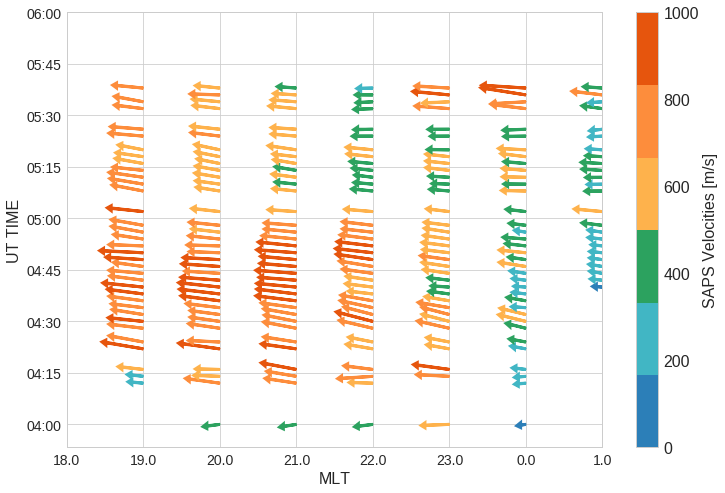

In [11]:
# setup data
plotMLTends = meanVelDF['endPtnormMlt'].tolist()#meanVelDF['endPtMlon'].tolist()#
plotmlatends = meanVelDF['endPtTime'].tolist()
plotMLTbegins = meanVelDF['normMlt'].tolist()#meanVelDF['Mlon'].tolist()#
plotmlatbegins = meanVelDF['time'].tolist()
plotVelMagns = meanVelDF['velSAPS'].tolist()
# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = saidTimeRange[0]
while currTime <= saidTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
    
lshellPlot = ax.scatter( x=meanVelDF["normMlt"], y=meanVelDF["time"],\
                     c=meanVelDF["velSAPS"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         print currMLTbgn, currMLTend
#         print currmlatbgn, currmlatend
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )   
#         ax.scatter( currMLTend, currmlatend , s=10, color=currCol, marker="<" )  
#         ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
#                  head_width=0.0015, head_length=0.075, fc=currCol, ec=currCol, ls='--')
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn,\
                 currmlatend-currmlatbgn, head_width=0.001,\
                 head_length=0.05, fc=currCol,width=0.0001,\
                 ec=currCol, lw='3')
        
ax.set_xlim( [-6,1] )
ax.set_yticks(yTickList)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xlabel('MLT', fontsize=16)
ax.set_ylabel('UT TIME', fontsize=16)

cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)


f.savefig("../plots/lshell-mean-timseries-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')